# 1. Import Libraries

In [16]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix ,precision_score, recall_score, roc_auc_score ,roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2. Load Data

In [ ]:
mon_features= pd.read_csv('/content/drive/MyDrive/Machine5/datasets/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/Machine5/datasets/mon_labels.csv')

# 3. Preprocess Data


In [ ]:
# Feature selection based on features/mon_feature_information
mon_features = mon_features[['total_num', 'total_sum_dir', 'inpkt_num', 'inpkt_avg_ordering',
       'inpkt_std_ordering', 'outpkt_num', 'outpkt_avg_ordering',
       'outpkt_std_ordering', 'inpkt_count_burst', 'outpkt_count_burst']]

In [19]:
X = mon_features
y = mon_labels

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Train/Test Shape:", X_train.shape, X_test.shape)

Data Train/Test Shape: (15200, 27) (3800, 27)


In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

# 4. Model selection

In [22]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [23]:
#하이퍼파라미터 튜닝(GridSearch)
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'max_leaf_nodes': [50, 100, 200, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='accuracy',  
    cv=3,  
    random_state=42,  
    n_jobs=-1 
)
random_search.fit(X_train, y_train)

/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(95, 95))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': None, 'class_weight': 'balanced_subsample'}
Best Score: 0.7081581086373246

Accuracy: 0.7186842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67        42
           1       0.61      0.52      0.56        42
           2       0.82      0.89      0.85        35
           3       0.73      0.83      0.77        29
           4       0.64      0.95      0.76        39
           5       0.93      0.89      0.91        45
           6       0.82      0.82      0.82        44
           7       0.60      0.81      0.69        36
           8       0.66      0.74      0.69        34
           9       0.49      0.68      0.57        31
          10       0.91      0.66      0.77        47
          11       0.79      0.63      0.70        35
          12       0.78      0.86      0.82 

In [ ]:
# 확률 예측 (predict_proba 활용)
y_pred_proba_selected = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_selected, pos_label=1)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_proba_selected, pos_label=1)
pr_auc = auc(recall_values, precision_values)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


ROC AUC: 0.9081
Precision-Recall AUC: 0.5622


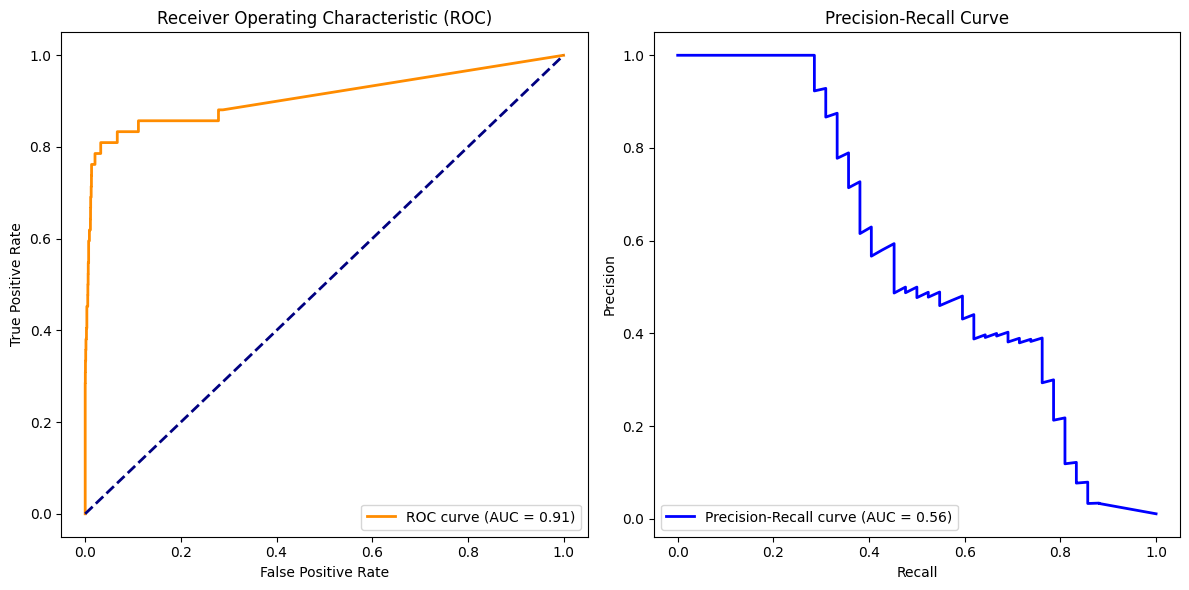

In [ ]:
# Plot ROC and Precision-Recall Curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()